# Exam project of group 26
### Group members:
- Baltazar Dydensborg
- Johan Kielgast Ladelund
- Laura Weile
- Simon Juul Hansen

### Research Question:
Vi skal have fundet på noget.


### All of the dependency imports

In [50]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import datetime
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

import time
from seleniumwire import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver import ActionChains
from collections import defaultdict
import scraping_class
from statsmodels.tsa.tsatools import lagmat


In [13]:
s = requests.Session()
# update headers to the requests
s.headers.update({'contact_details': 'qxd466@alumni.ku.dk', 'purpose': "Dear recipient, we've scraped your data with the purpose of creating an academic report on electricity prices and if it's possible to predict these. Please contact us at via the contact details, if there's any issue with this. Best regards."})
conn = scraping_class.Connector(logfile="log.csv", overwrite_log=True, session = s)

# Nordpool data


We import the required packages

We identify the [webpage](https://www.nordpoolgroup.com/historical-market-data/) with the desired information stored as seperate htlm files.

However, we are not able to scrape Nordpool to obtain the individual links for the files as the webpage call an internal API. Luckily we are able to call the API and obtain the JSON. 

## Below we define function for data gathering and handling of all Nordpool data

In [14]:
### We define a function for getting the electricity spot prices ###
def getElspotPrices():
    # Get the json data from Nordpool
    url = 'https://www.nordpoolgroup.com/api/downloads/4675'
    el_res, _ = conn.get(url, "Nordpool Data")
    el_json = el_res.json()

    # Selects the urls for the hourly elspot prices in DKK
    hourly = [i for i in el_json['Files'] if i['Resolution'] == 'Hourly']
    elspot = [i for i in hourly if i['Categories'] == ['Elspot Prices']]
    elspot = [i for i in elspot if i['Name'].endswith('DKK')]
    elspot_url = ['https://www.nordpoolgroup.com'+i['Url'] for i in elspot]

    # Create a dictonary with all of the data for each year and put it into a DataFrame
    d = {}
    for i in range(len(elspot_url)):
        d[f'DF_{2013+i}'] = pd.read_html(elspot_url[i])[0].droplevel(level = 0, axis = 1).droplevel(level = 0, axis = 1)

    # Standardize the 2021 dataset
    #d['DF_2021'] = d['DF_2021'].droplevel(level = 0, axis = 1).rename(columns= {'Unnamed: 0_level_3': 'Unnamed: 0_level_2'})

    # Concat the DataFrames into one DF
    df_concat = pd.concat(d)

    # Structure the DataFrame
    df_new = df_concat[['Unnamed: 0_level_2', 'Hours','DK1']].droplevel(level = 0).reset_index(drop = True)
    df_new[df_new.columns[2:]] = df_new[df_new.columns[2:]]/100
    df_new = df_new.rename(columns = {'Unnamed: 0_level_2': 'date'})

    # Add datetime columns
    df_new['date'] = pd.to_datetime(df_new['date'], format = '%d-%m-%Y')
    df_new['hour'] = df_new['Hours'].str[5:]
    df_new.drop('Hours', axis = 1, inplace = True)
    df_new['hour'] = pd.to_datetime(df_new['hour'], format = '%H').dt.hour

    # Make the index into datetime
    df_new.index = pd.to_datetime(df_new['date'].apply(str)+' '+pd.to_datetime(df_new['hour'], format = '%H').dt.time.apply(str))

    return df_new

### We define a function for getting the electricity consumption prognosis ###
def ConsumptionPrognosis():
    # Get the json from the internal API on Nordpool.com
    url = "https://www.nordpoolgroup.com/api/downloads/4675"
    res, _ = conn.get(url, "Nordpool Data")
    page = res.json()

    # Get the URLs for the html files containing the hourly consumption prognosis' and transform them into a list
    # of dataframes 
    hourly = [i for i in page["Files"] if i["Resolution"] == "Hourly"]
    Categories = [i for i in hourly if i["Categories"] == ["Consumption prognosis"]]
    DKK = [i for i in Categories if "DK" in i["Name"]]
    URLS_CP = ["https://www.nordpoolgroup.com"+i["Url"] for i in DKK]
    df_con_prog = [pd.read_html(i)[0].droplevel(level = 0, axis = 1).droplevel(level = 0, axis = 1) for i in URLS_CP]

    # Concatenate the dataframes, rename, and format time stamp
    df_CP = pd.concat(df_con_prog)
    cols = ["Unnamed: 0_level_2", "Hours", "DK1", "DK2"]
    df_CP = df_CP[cols].rename(columns = {"Unnamed: 0_level_2": "date", "DK1": "DK1_CP", "DK2": "DK2_CP"})
    df_CP["date"] = pd.to_datetime(df_CP["date"], format = "%d-%m-%Y")
    df_CP["hour"] = df_CP["Hours"].str[5:]
    df_CP.drop('Hours', axis = 1, inplace = True)
    df_CP["hour"] = pd.to_datetime(df_CP["hour"], format = '%H').dt.hour

    # Set index equal to time stamp 
    df_CP.index = pd.to_datetime(df_CP["date"].apply(str)+' '+pd.to_datetime(df_CP["hour"], format = '%H').dt.time.apply(str))

    return df_CP

### Production Prognosis ###
# We extract the production prognosis. The decimal pointer are correct for the consumption prognosis data sets.
def ProductionPrognosis(): 
    # Get the json from the internal API on Nordpool.com
    url = "https://www.nordpoolgroup.com/api/downloads/4675"
    res, _ = conn.get(url, "Nordpool Data")
    page = res.json()

    # Get the URLs for the html files containing the hourly consumption prognosis' and transform them into a list
    # of dataframes 
    hourly = [i for i in page["Files"] if i["Resolution"] == "Hourly"]
    Categories = [i for i in hourly if i["Categories"] == ["Production prognosis"]]
    URLS_PP = ["https://www.nordpoolgroup.com"+i["Url"] for i in Categories]
    df_pro_prog = [pd.read_html(i)[0].droplevel(level = 0, axis = 1).droplevel(level = 0, axis = 1) for i in URLS_PP]

    # Concatenate the dataframes, rename, and format time stamp
    df_PP = pd.concat(df_pro_prog)
    cols = ["Unnamed: 0_level_2", "Hours", "DK1", "DK2"]
    df_PP = df_PP[cols].rename(columns = {"Unnamed: 0_level_2": "date", "DK1": "DK1_PP", "DK2": "DK2_PP"})
    df_PP["date"] = pd.to_datetime(df_PP["date"], format = "%d-%m-%Y")
    df_PP["hour"] = df_PP["Hours"].str[5:]
    df_PP.drop('Hours', axis = 1, inplace = True)
    df_PP["hour"] = pd.to_datetime(df_PP["hour"], format = '%H').dt.hour


    # Set index equal to time stamp 
    df_PP.index = pd.to_datetime(df_PP["date"].apply(str)+' '+pd.to_datetime(df_PP["hour"], format = '%H').dt.time.apply(str))

    return df_PP

### Wind Power Prognosis ###
# We extract the wind power prognosis. The decimal pointer are correct for the consumption prognosis data sets.
def WindPrognosis():
    # Get the json from the internal API on Nordpool.com
    url = "https://www.nordpoolgroup.com/api/downloads/4675"
    res, _ = conn.get(url, "Nordpool Data")
    page = res.json()

    # Get the URLs for the html files containing the hourly consumption prognosis' and transform them into a list
    # of dataframes 
    hourly = [i for i in page["Files"] if i["Resolution"] == "Hourly"]
    Categories = [i for i in hourly if i["Categories"] == ["Wind power prognosis"]]
    DKK = [i for i in Categories if "DK" in i["Name"]]
    URLS_WP = ["https://www.nordpoolgroup.com"+i["Url"] for i in DKK]
    df_wind_prog = [pd.read_html(i)[0].droplevel(level = 0, axis = 1).droplevel(level = 0, axis = 1) for i in URLS_WP]

    # Concatenate the dataframes, rename, and format time stamp
    df_WP = pd.concat(df_wind_prog)
    cols = ["Unnamed: 0_level_2", "Hours", "DK1", "DK2"]
    df_WP = df_WP[cols].rename(columns = {"Unnamed: 0_level_2": "date", "DK1": "DK1_WP", "DK2": "DK2_WP"})
    df_WP["date"] = pd.to_datetime(df_WP["date"], format = "%d-%m-%Y")
    df_WP["hour"] = df_WP["Hours"].str[5:]
    df_WP.drop('Hours', axis = 1, inplace = True)
    df_WP["hour"] = pd.to_datetime(df_WP["hour"], format = '%H').dt.hour


    # Set index equal to time stamp 
    df_WP.index = pd.to_datetime(df_WP["date"].apply(str)+' '+pd.to_datetime(df_WP["hour"], format = '%H').dt.time.apply(str))

    return df_WP

### Power Exchange ###
# We extract the power exchange. We change the value og observation to fix the misplaced decimal pointer when relevant. 
def ExchangeConnections():
    # Get the json from the internal API on Nordpool.com
    url = "https://www.nordpoolgroup.com/api/downloads/4675"
    res, _ = conn.get(url, "Nordpool Data")
    page = res.json()

    # Get the URLs for the html files containing the hourly consumption prognosis' and transform them into a list
    # of dataframes 
    hourly = [i for i in page["Files"] if i["Resolution"] == "Hourly"] 
    Categories = [i for i in hourly if i["Categories"] == ["Exchange connections"]]
    DKK = [i for i in Categories if "DK" in i["Name"]]
    URLS_Ex = ["https://www.nordpoolgroup.com"+i["Url"] for i in DKK]

    # We obain two datasets for 2015 and by inspecting the data sets we realize that the set called: 
    # 'https://www.nordpoolgroup.com/48e277/globalassets/marketdata-excel-files/exchange-dk-connections_2015_hourly2.xls',
    # is the data of intereset
    
    URLS_Ex.pop(2)
    df_Exchange = [pd.read_html(i)[0].droplevel(level = 0, axis = 1).droplevel(level = 0, axis = 1) for i in URLS_Ex]

    # Concatenate the dataframes, rename, fix misplaced decimal pointer, and format time stamp
    df_Ex = pd.concat(df_Exchange)
    df_Ex = df_Ex.rename(columns = {"Unnamed: 0_level_2": "date"})
    df_Ex["date"] = pd.to_datetime(df_Ex["date"], format = "%d-%m-%Y")

    df_Ex["hour"] = df_Ex["Hours"].str[5:]
    df_Ex.drop('Hours', axis = 1, inplace = True)
    df_Ex["hour"] = pd.to_datetime(df_Ex["hour"], format = '%H').dt.hour

    cols = ["DK - DE", "DK - NO", "DK - SE", "DK1 - SE3", "DK2 - SE4", "DK1 - DE", "DK2 - DE", "DK1 - DK2", "DK1 - NL"]
    df_Ex[cols] = df_Ex[cols]/100

    # Set index equal to time stamp 
    df_Ex.index = pd.to_datetime(df_Ex["date"].apply(str)+' '+pd.to_datetime(df_Ex["hour"], format = '%H').dt.time.apply(str))

    return df_Ex

### Merging all Nordpool data together into one DataFrame ###
# Creating function to merge dataframes from the Nordpool database
def mergeNordpool(list_of_dfs):
    df_Nordpool = list_of_dfs[0]
    for df in list_of_dfs[1:]:
        df_Nordpool = pd.merge(df_Nordpool, df, how = "outer", on = ["date", "hour"])
    df_Nordpool.reset_index(drop = True)
    return df_Nordpool


# Weather data from DMI API

In [15]:
# Constants

metObsAPIKey = 'c4503ba1-28d4-45c5-850a-974e98bbb3e0'
climateDataAPIKey = 'ac27b332-bde2-4138-a53e-f0ca82cf3667'

## Defining functions to be used for gathering and handling the DMI weather data

In [16]:
### Defining a function to extract data from the DMI metObs APi ### 
def getMetObsData(stat, start_date, end_date, stationId = '06183', apiKey = metObsAPIKey):
    """
    Function that takes a parameter ID and searches for all observations from DMI
    for the given dates, where the date format is given as 'YYYY-MM-DD'
    """

    # Define constants to be used in the function
    url= lambda API_KEY, id, startDate, endDate, stationId: f'https://dmigw.govcloud.dk/v2/metObs/collections/observation/items?limit=300000&stationId={stationId}&parameterId={id}&bbox=7,54,16,58&datetime={startDate}T00:00:00Z/{endDate}T00:00:00Z&api-key={API_KEY}'
    local_counter = 1
    ErrorCounter = 0
    stationCounter = 0

    while True:
        try:
            temp_url = url(apiKey, stat, start_date, end_date, stationId)
            ErrorCounter += 1

            res, _ = conn.get(temp_url, 'DMI Data')
            json_dmi = res.json()
            prop = [item['properties'] for item in json_dmi['features']]
            temp_df = pd.DataFrame(prop)
            
            temp_df['observed'].drop_duplicates(inplace = True)
            temp_df.index = pd.to_datetime(temp_df['observed'])
            temp_df = temp_df.tz_convert('CET')

            if temp_df.index[-1].date() != datetime.date.fromisoformat(start_date):
                            
                if local_counter == 1:
                    df_met_obs_func = temp_df.copy()
                    local_counter += 1
                elif local_counter > 1:
                    df_met_obs_func = pd.concat([df_met_obs_func,temp_df])
                else:
                    warnings.warn("Something went wrong with the local counter in IF")

                end_date = temp_df.index[-1].date().strftime("%Y-%m-%d")
                continue
            else:
                if local_counter == 1:
                    df_met_obs_func = temp_df
                elif local_counter > 1:
                    df_met_obs_func = pd.concat([df_met_obs_func,temp_df])
                else:
                    warnings.warn("Something went wrong with the local counter in ELSE")

                break
            


        except KeyError as e:

            try:
                df_met_obs_func
            except NameError:
                return temp_df
            else:
                return df_met_obs_func
        
    return df_met_obs_func

### Defining a function that will fill in the NaN with data from other DMI weather stations for the metObs data###        
def metObsNaFiller(stat, start_date, end_date):
    stationList = ['06184', '06186', '06187', '06188']

    # Create the DF for the first and default station
    df = getMetObsData(stat, start_date, end_date)

    # Fill in the NAs with observations from all stations listed above
    for station in stationList:
        df = df.combine_first(getMetObsData(stat, start_date, end_date, stationId = station))

    return df

### Defining a function to extract data from the DMI ClimateData APi ### 
def getClimateData(stat, start_date, end_date, stationId = '06184',apiKey = climateDataAPIKey):
    """
    Function that takes a parameter ID and searches for all observations from DMI
    for the given dates, where the date format is given as 'YYYY-MM-DD'
    """

    # Define constants to be used in the function
    url= lambda API_KEY, id, startDate, endDate, stationId: f'https://dmigw.govcloud.dk/v2/climateData/collections/stationValue/items?timeResolution=hour&limit=300000&stationId={stationId}&parameterId={id}&datetime={startDate}T00:00:00Z/{endDate}T00:00:00Z&api-key={API_KEY}'
    local_counter = 1
    ErrorCounter = 0
    stationCounter = 0

    while True:
        try:
            temp_url = url(apiKey, stat, start_date, end_date, stationId)
            ErrorCounter += 1

            res, _ = conn.get(temp_url, 'DMI Data')
            json_dmi = res.json()
            prop = [item['properties'] for item in json_dmi['features']]
            temp_df = pd.DataFrame(prop)
            
            temp_df['to'].drop_duplicates(inplace = True)
            temp_df.index = pd.to_datetime(temp_df['to'])

            if temp_df.index[-1].date() != datetime.date.fromisoformat(start_date):
                            
                if local_counter == 1:
                    df_climate_func = temp_df.copy()
                    local_counter += 1
                elif local_counter > 1:
                    df_climate_func = pd.concat([df_climate_func,temp_df])
                else:
                    warnings.warn("Something went wrong with the local counter in IF")

                end_date = temp_df.index[-1].date().strftime("%Y-%m-%d")
                continue
            else:
                if local_counter == 1:
                    df_climate_func = temp_df
                elif local_counter > 1:
                    df_climate_func = pd.concat([df_climate_func,temp_df])
                else:
                    warnings.warn("Something went wrong with the local counter in ELSE")

                break
            


        except KeyError as e:

            try:
                df_climate_func
            except NameError:
                return temp_df
            else:
                return df_climate_func
        
    return df_climate_func

### Defining a function that will fill in the NaN with data from other DMI weather stations for the Climate data ###        
def ClimateNaFiller(stat, start_date, end_date):
    stationList = ['06181', '06186', '06187', '06188']

    # Create the DF for the first and default station
    df = getClimateData(stat, start_date, end_date)

    # Fill in the NAs with observations from all stations listed above
    for station in stationList:
        df = df.combine_first(getClimateData(stat, start_date, end_date, stationId = station))

    return df

### Transforming the metObs data so that it goes from long format to wide format and has date and hour columns ###
def transformMetObsData(df):
    df = df
    df['hour'] = df.index.hour
    df['date'] = df.index.date
    df = df.drop_duplicates(['parameterId', 'date','hour'])\
            .drop(['created', 'stationId'], axis = 1)\
            .sort_values(by = ['date', 'hour'], ascending = [False, False])\
            .copy()
    
    df_new = df.groupby(['parameterId', 'date', 'hour'])['value'].mean()\
            .unstack(level = 0)\
            .reset_index().rename(columns={df.index.name:None})

    return df_new
    
### Transforming the Climate data so that it goes from long format to wide format and has date and hour columns ###
def transformClimateData(df):
    df = df
    df = df.tz_convert('CET')
    df['hour'] = df.index.hour
    df['date'] = df.index.date
    df = df.drop_duplicates(['parameterId', 'date','hour'])\
            .drop(['calculatedAt', 'created', 'from', 'qcStatus', 'timeResolution', 'validity'], axis = 1)\
            .sort_values(by = ['date', 'hour'], ascending = [False, False])\
            .copy()
    
    df_new = df.groupby(['parameterId', 'date', 'hour'])['value'].mean()\
            .unstack(level = 0)\
            .reset_index().rename(columns={df.index.name:None})

    return df_new

### Function that handles the total procesing of metObs data ###
def metObsPipeline(stats, start_date, end_date):
    dict_df = dict()
    for stat in tqdm(stats):
        dict_df[stat] = metObsNaFiller(stat, start_date, end_date)

    new_df_met = pd.concat(dict_df.values())
    transform_df_met = transformMetObsData(new_df_met)
    return transform_df_met

### Function that handles the total procesing of Climate data ###
def climatePipeline(stats, start_date, end_date):
    dict_df = dict()
    for stat in tqdm(stats):
        dict_df[stat] = ClimateNaFiller(stat, start_date, end_date)

    new_df_climate = pd.concat(dict_df.values())
    transform_df_climate = transformClimateData(new_df_climate)
    return transform_df_climate

### Function that merges the metObs and Climate data together into a single DataFrame ###
def merger(df_met, df_climate, start_date, end_date):
    index1 = pd.date_range(start=start_date, end=end_date, freq = 'H').to_pydatetime().tolist()
    dfindex = pd.DataFrame(index = index1)
    dfindex['date'] = dfindex.index.date
    dfindex['hour'] = dfindex.index.hour
    merge_df = dfindex.reset_index()\
            .merge(df_met, how="left", on = ['date', 'hour'])\
            .merge(df_climate, how = 'left', on = ['date', 'hour'])\
            .set_index('index')\
            .sort_index()

    return merge_df

### This function handles all of the DMI data handling by calling the above functions ###
def total_DMI_pipeline(met_stats, climate_stats, start_date, end_date):
    print('INFO: Running metObs pipeline')
    df_met = metObsPipeline(met_stats, start_date, end_date)
    print('INFO: Running Climate data pipeline')
    df_climate = climatePipeline(climate_stats, start_date, end_date)
    print('INFO: Merging the climate and metObs data together')
    df_total = merger(df_met, df_climate, start_date, end_date)
    print('INFO: Done')
    return df_total

# Getting commodity data from https://www.investing.com/
In the below code, you will need to change the ***path*** variable to fit the location of your ChromeDriver, otherwise the code will fail.

In [17]:
### List of all the commodities we will exctract data on from the website ###
list_of_commodities = ['gold', 'silver', 'crude-oil', 'rotterdam-coal-futures', 'natural-gas', 'carbon-emissions']

### Function that scrapes data for a given commodity and date range from the website using Selenium ###
def getCommodityData(commodity, startDate, endDate):
    # The commodity has to be specified in the form of '-'.join(commodity_name) e.g. rotterdam-coal-futures or crude-oil.
    url = lambda id: f'https://www.investing.com/commodities/{id}-historical-data'
    temp_url = url(commodity)
    startDate = datetime.datetime.strptime(startDate, "%Y-%m-%d").strftime('%m/%d/%Y')
    endDate = datetime.datetime.strptime(endDate, "%Y-%m-%d").strftime('%m/%d/%Y')

    # Insert the path to your Chrome Driver.
    path = '/Users/simonjuulhansen/Desktop/Polit/ISDS/chromedriver'
    driver = webdriver.Chrome(executable_path=path)

    # Create a request interceptor that will contain the request header for Selenium requests
    def interceptor(request):
        request.headers['Contact_details'] = 'qxd466@alumni.ku.dk'
        request.headers['Purpose'] = "Dear recipient, we've scraped your data with the purpose of creating an academic report on electricity prices and if it's possible to predict these. Please contact us at via the contact details, if there's any issue with this. Best regards."

    # Set the interceptor on the driver
    driver.request_interceptor = interceptor
    
    driver.get(temp_url)
    
    time.sleep(3)

    # Accept cookies
    cookies = driver.find_element_by_css_selector('#onetrust-accept-btn-handler')
    ActionChains(driver).click(cookies).perform()

    time.sleep(1)

    # Opens the date range menu
    menu = driver.find_element_by_css_selector('#widgetFieldDateRange')
    ActionChains(driver).click(menu).perform()

    # Enters the date values. The dates have to be in the form of DD/MM/YYYY e.g. 01/01/2000.
    # This formatting is done in the above conversion of the start and end date from YYYY-MM-DD.
    inputElement1 = driver.find_element_by_id("startDate")
    inputElement1.clear()
    inputElement1.send_keys(startDate)

    inputElement2 = driver.find_element_by_id("endDate")
    inputElement2.clear()
    inputElement2.send_keys(endDate)

    # Applies the new dates
    driver.find_element_by_id("applyBtn").click();

    time.sleep(3)

    # Gets the results from the webpage
    results = driver.find_elements_by_xpath('//*[(@id = "curr_table")]//td')

    # Store the results in a DataFrame
    d = defaultdict(list)
    date_counter = 0
    value_counter = 1
    while True:
        try:
            d['date'].append(results[date_counter].text)
            d[commodity].append(results[value_counter].text)
            date_counter += 7
            value_counter += 7
        except IndexError:
            break
    df = pd.DataFrame(d)
    df['date'] = pd.to_datetime(df['date'], format = '%b %d, %Y')

    driver.quit()
    
    return df

### Function that gathers all of the commodity data and puts them into one single DataFrame, where NaN has been forward filled (daily data) ###
def getAllCommodities(commodities, startDate, endDate):
    dict_df = dict()

    for i in tqdm(commodities):
        print(f'INFO: Gathering commodity data for {i}')
        dict_df[i] = getCommodityData(i, startDate, endDate)

    date_range = pd.date_range(start=startDate, end=endDate, freq = 'D').to_pydatetime().tolist()
    df = pd.DataFrame(date_range, columns = ['date'])

    for i in dict_df.values():
        df = df.merge(i, on = 'date', how = 'left')
        df[i.columns[-1]] = df[i.columns[-1]].str.replace(',','').astype('float')

    df = df.ffill()
    return df

# Total data gathering and handling

### Running the below cell will gather and wrangle all of the data from DMI, Nordpool and investing.com.
This might take a while, e.g. 20-30 min.
Remember that the commodity price functions will fail unless you have amended the path in the above cell to match the path to your ChromeDriver.

Running the below code cell will give some Selenium warnings, however, we've not found these to impact the performance or result of the code. These warnings are a symptom of including the header in the Selenium HTTP request, i.e., they do not appear if we remove the header (use Selenium and not SeleniumWire)

In [19]:
startDate = '2016-04-01'
endDate = '2021-01-01'

# Gathering Nordpool data 
#df_Nordpool = mergeNordpool([getElspotPrices(), ConsumptionPrognosis(), ProductionPrognosis(), WindPrognosis(), ExchangeConnections()])

# Gathering DMI weather data
metObs_listV2 = [ 'wind_max_per10min_past1h', 'temp_soil_max_past1h', 'cloud_cover']
climate_listV1 = ['bright_sunshine', 'mean_radiation', 'mean_pressure', 'acc_precip', 'temp_grass', 'mean_relative_hum', 'mean_temp', 'mean_wind_speed' ,'mean_wind_dir']
df_dmi = total_DMI_pipeline(metObs_listV2, climate_listV1, startDate, endDate)

# Gathering commodity data
list_of_commodities = ['gold', 'silver', 'crude-oil', 'rotterdam-coal-futures', 'natural-gas', 'carbon-emissions']
commodities_df = getAllCommodities(list_of_commodities, startDate, endDate)

  0%|          | 0/3 [00:00<?, ?it/s]

INFO: Running metObs pipeline


  0%|          | 0/9 [00:00<?, ?it/s]

INFO: Running Climate data pipeline


  0%|          | 0/6 [00:00<?, ?it/s]

INFO: Merging the climate and metObs data together
INFO: Done
INFO: Gathering commodity data for gold


 17%|█▋        | 1/6 [01:26<07:12, 86.54s/it]

INFO: Gathering commodity data for silver


127.0.0.1:53715: Traceback (most recent call last):
  File "/usr/local/lib/python3.9/site-packages/seleniumwire/thirdparty/mitmproxy/server/modes/http_proxy.py", line 9, in __call__
    layer()
  File "/usr/local/lib/python3.9/site-packages/seleniumwire/thirdparty/mitmproxy/server/protocol/tls.py", line 285, in __call__
    layer()
  File "/usr/local/lib/python3.9/site-packages/seleniumwire/thirdparty/mitmproxy/server/protocol/http1.py", line 100, in __call__
    layer()
  File "/usr/local/lib/python3.9/site-packages/seleniumwire/thirdparty/mitmproxy/server/protocol/http.py", line 206, in __call__
    if not self._process_flow(flow):
  File "/usr/local/lib/python3.9/site-packages/seleniumwire/thirdparty/mitmproxy/server/protocol/http.py", line 285, in _process_flow
    return self.handle_regular_connect(f)
  File "/usr/local/lib/python3.9/site-packages/seleniumwire/thirdparty/mitmproxy/server/protocol/http.py", line 224, in handle_regular_connect
    layer()
  File "/usr/local/lib/pyth

INFO: Gathering commodity data for crude-oil


 50%|█████     | 3/6 [04:12<04:08, 82.90s/it]

INFO: Gathering commodity data for rotterdam-coal-futures


 67%|██████▋   | 4/6 [05:10<02:25, 72.84s/it]

INFO: Gathering commodity data for natural-gas


 83%|████████▎ | 5/6 [06:23<01:13, 73.13s/it]

INFO: Gathering commodity data for carbon-emissions


100%|██████████| 6/6 [07:35<00:00, 75.97s/it]


The below gathers the ***old*** DMI data, i.e., where we were gathering data and returning only a DataFrame for a single station and not a combination of data from all given stations. This, as can be seen below, does give us plenty of NA's as the DMI data is far from *pretty*.

In [58]:
df_old_dmi = old_total_DMI_pipeline(metObs_listV2, climate_listV1, startDate, endDate)

  0%|          | 0/3 [00:00<?, ?it/s]

INFO: Running metObs pipeline


  0%|          | 0/9 [00:00<?, ?it/s]

INFO: Running Climate data pipeline


100%|██████████| 9/9 [01:10<00:00,  7.89s/it]


INFO: Merging the climate and metObs data together
INFO: Done


array([[<AxesSubplot:xlabel='index'>, <AxesSubplot:xlabel='index'>,
        <AxesSubplot:xlabel='index'>, <AxesSubplot:xlabel='index'>],
       [<AxesSubplot:xlabel='index'>, <AxesSubplot:xlabel='index'>,
        <AxesSubplot:xlabel='index'>, <AxesSubplot:xlabel='index'>],
       [<AxesSubplot:xlabel='index'>, <AxesSubplot:xlabel='index'>,
        <AxesSubplot:xlabel='index'>, <AxesSubplot:xlabel='index'>],
       [<AxesSubplot:xlabel='index'>, <AxesSubplot:xlabel='index'>,
        <AxesSubplot:xlabel='index'>, <AxesSubplot:xlabel='index'>]],
      dtype=object)

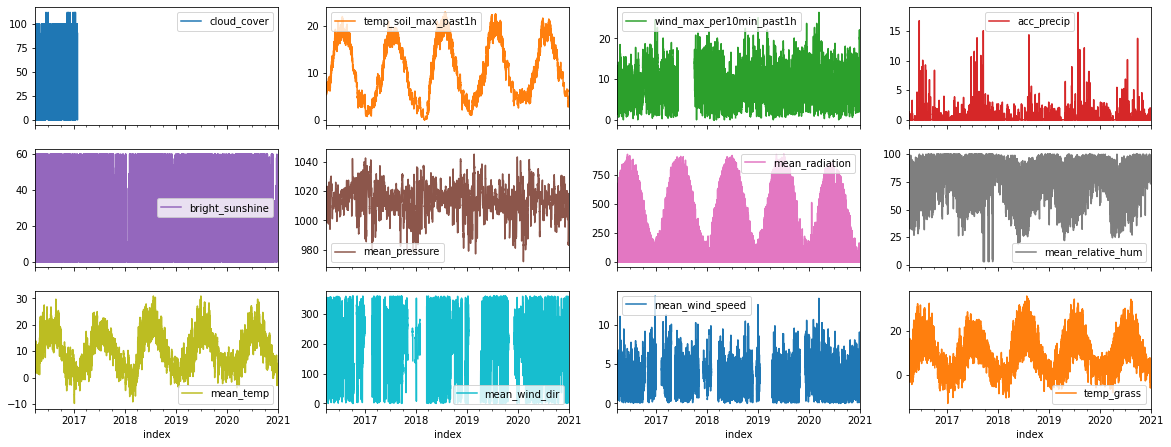

In [64]:
len(df_old_dmi.columns)
df_old_dmi[df_old_dmi.columns[2:]].plot(subplots=True, layout=(4,4), figsize = (20,10), sharex=True);

Below is the new approach to gathering DMI data, i.e., filling in all NA's with observations from other stations to combine one DataFrame

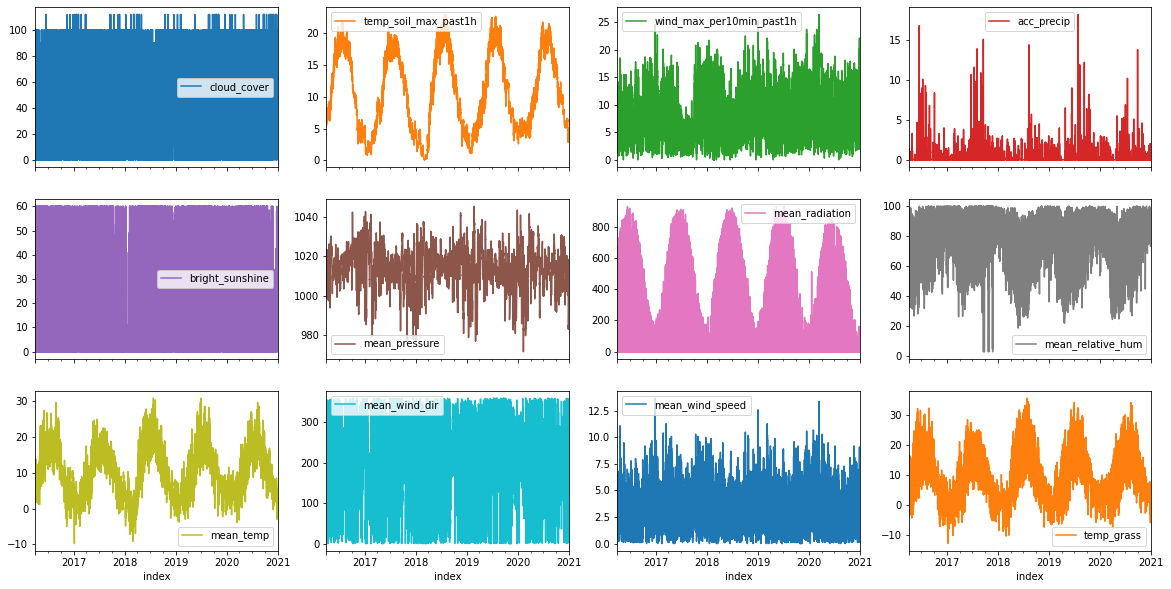

In [67]:
df_dmi[df_dmi.columns[2:]].plot(subplots=True, layout = (3,4), figsize = (20,10), sharex=True);

## The below transforms all of the above dataframes into a single master DataFrame

In [85]:
def total_dataframe(df_nordpool, df_dmi, df_commodities):

    # Below we're merging all of the data together into one DataFrame from all 3 input DF's
    df_nordpool_new = df_nordpool.copy()
    df_nordpool_new['date'] = df_nordpool_new['date'].astype('string')

    df_dmi_new = df_dmi.copy()
    df_dmi_new['date'] = df_dmi_new['date'].astype('string')

    df_commodities_new = df_commodities.copy()
    df_commodities_new['date'] = df_commodities_new['date'].astype('string')

    first_merge = df_dmi_new.merge(df_nordpool_new, on = ['date', 'hour'], how = 'left')
    second_merge = first_merge.merge(df_commodities_new, on = 'date', how = 'left')

    # Deleting unneeded columns, NaN's and duplicates.
    # The duplicates were only for changes to wintertime, where there were one duplicate for each year at 3 AM, but with different values
    # for each of the 3 AM observations due to winter time.
    # The mean of those two were taken and are replacing the duplicated hours
    second_merge.drop(['DK1 - NL'], axis = 1, inplace = True)
    second_merge.dropna(inplace = True)
    new_mean = second_merge[second_merge.duplicated(['date', 'hour'])].groupby(['date', 'hour']).mean().reset_index()
    second_merge.drop_duplicates(['date', 'hour'],  keep = False, inplace = True)
    df_concat = pd.concat([second_merge, new_mean]).sort_values(['date', 'hour']).reset_index(drop = True)

    df_concat.ffill(inplace = True)
    df_concat.dropna(inplace = True)

    # Below we're generating hour, weekday and month dummies and appending them to the DataFrame 
    # while also converting the index to a Datetime object in the main DataFrame
    df_concat.index = pd.to_datetime(df_concat['date'].apply(str)+' '+pd.to_datetime(df_concat['hour'], format = '%H').dt.time.apply(str))
    df_concat['month'] = df_concat.index.month
    df_concat['weekday'] = df_concat.index.weekday

    d = defaultdict(list)

    d[0] = pd.get_dummies(df_concat['hour'], prefix = 'hour')
    d[1] = pd.get_dummies(df_concat['weekday'], prefix = 'weekday')
    d[2] = pd.get_dummies(df_concat['month'], prefix = 'month')
    df_join = df_concat.copy()
    for i in d.values():
        df_join = df_join.join(i)


    # Below we're lagging the variables to comply with the time series element of our regression
    # as to not create future leakage

    # Lagging the DK1 prices 48 times and only keeping the 24-48 lags
    lagged_DK1 = lagmat(df_join['DK1'], 48, use_pandas = True, trim = 'both')
    lagged_DK1 = lagged_DK1[lagged_DK1.columns[23:]]

    # Lagging the commodity data once by 24 hours
    d_lag_commodity = {}
    list_of_commodities = ['gold', 'silver', 'crude-oil', 'rotterdam-coal-futures', 'natural-gas', 'carbon-emissions']
    for i in list_of_commodities:
        d_lag_commodity[i] = lagmat(df_join[i], 24, use_pandas = True, trim = 'both')
        d_lag_commodity[i] = d_lag_commodity[i][d_lag_commodity[i].columns[23]]
    df_lag_commodity = pd.concat(d_lag_commodity.values(), axis = 1)

    # Lagging the exchange data once
    exchange_list = ['DK net exchange', 'DK1 net exchange', 'DK2 net exchange', 'DK - DE',
       'DK - NO', 'DK - SE', 'DK1 - SE3', 'DK2 - SE4', 'DK1 - DE', 'DK2 - DE',
       'DK1 - DK2']
    d_lag_exchange = {}
    for i in exchange_list:
        d_lag_exchange[i] = lagmat(df_join[i], 24, use_pandas = True, trim = 'both')
        d_lag_exchange[i] = d_lag_exchange[i][d_lag_exchange[i].columns[23]]
    df_lag_exchange = pd.concat(d_lag_exchange.values(), axis = 1)

    # Appending all lags to the DataFrame
    list_of_df_lags = [df_lag_commodity, df_lag_exchange, lagged_DK1]
    for i in list_of_df_lags:
        df_join = df_join.join(i)
    
    # Dropping original non-lagged columns except the target, DK1
    df_join = df_join.dropna().drop(exchange_list+list_of_commodities+['month', 'weekday', 'date', 'hour'], axis = 1)
    df_join.drop(['weekday_0', 'hour_0', 'month_1'], axis = 1, inplace = True)

    # Adding a trend column to detrend
    df_join['trend'] = [i+1 for i in range(len(df_join))]

    return df_join

In [86]:
df_all_data = total_dataframe(df_Nordpool, df_dmi, commodities_df)

In [88]:
df_all_data.to_csv('dfV2.csv')

# DEPRECIATED FUNCTIONS

In [54]:
def oldClimateData(stat, start_date, end_date, stationId = '06184',apiKey = climateDataAPIKey):
    """
    Function that takes a parameter ID and searches for all observations from DMI
    for the given dates, where the date format is given as 'YYYY-MM-DD'
    """

    # Define constants to be used in the function
    url= lambda API_KEY, id, startDate, endDate, stationId: f'https://dmigw.govcloud.dk/v2/climateData/collections/stationValue/items?timeResolution=hour&limit=300000&stationId={stationId}&parameterId={id}&datetime={startDate}T00:00:00Z/{endDate}T00:00:00Z&api-key={API_KEY}'
    local_counter = 1
    ErrorCounter = 0
    stationCounter = 0
    stationList = ['06181', '06186', '06187', '06188']

    while True:
        try:
            temp_url = url(apiKey, stat, start_date, end_date, stationId)
            ErrorCounter += 1

            res, _ = conn.get(temp_url, 'DMI Data')
            json_dmi = res.json()
            prop = [item['properties'] for item in json_dmi['features']]
            temp_df = pd.DataFrame(prop)
            
            temp_df['to'].drop_duplicates(inplace = True)
            temp_df.index = pd.to_datetime(temp_df['to'])
            #temp_df = temp_df.tz_convert('CET')

            if temp_df.index[-1].date() != datetime.date.fromisoformat(start_date):
                            
                if local_counter == 1:
                    df = temp_df.copy()
                    local_counter += 1
                elif local_counter > 1:
                    df = pd.concat([df,temp_df])
                else:
                    warnings.warn("Something went wrong with the local counter in IF")

                end_date = temp_df.index[-1].date().strftime("%Y-%m-%d")
                #warnings.warn('Loop loop date wrong')
                continue
            else:
                if local_counter == 1:
                    df = temp_df
                elif local_counter > 1:
                    df = pd.concat([df,temp_df])
                else:
                    warnings.warn("Something went wrong with the local counter in ELSE")

                break
            


        except KeyError as e:

            try:
                stationId = stationList[stationCounter]
                stationCounter += 1
                #warnings.warn('Loop loop station wrong')
                continue
            except IndexError as i:
                if ErrorCounter == 1:
                    warnings.warn(f"The requested stat {stat} isn't available for any default stations")
                else:
                    warnings.warn(f"The requested stat {stat} isn't available for any default stations for the daterange: {start_date} - {end_date}")
                return None
        
    return df


In [55]:
def oldMetObsData(stat, start_date, end_date, stationId = '06183', apiKey = metObsAPIKey):
    """
    Function that takes a parameter ID and searches for all observations from DMI
    for the given dates, where the date format is given as 'YYYY-MM-DD'
    """

    # Define constants to be used in the function
    url= lambda API_KEY, id, startDate, endDate, stationId: f'https://dmigw.govcloud.dk/v2/metObs/collections/observation/items?limit=300000&stationId={stationId}&parameterId={id}&bbox=7,54,16,58&datetime={startDate}T00:00:00Z/{endDate}T00:00:00Z&api-key={API_KEY}'
    local_counter = 1
    ErrorCounter = 0
    stationCounter = 0
    stationList = ['06184', '06186', '06187', '06188']

    while True:
        try:
            temp_url = url(apiKey, stat, start_date, end_date, stationId)
            ErrorCounter += 1

            res, _ = conn.get(temp_url, 'DMI Data')
            json_dmi = res.json()
            prop = [item['properties'] for item in json_dmi['features']]
            temp_df = pd.DataFrame(prop)
            
            temp_df['observed'].drop_duplicates(inplace = True)
            temp_df.index = pd.to_datetime(temp_df['observed'])
            temp_df = temp_df.tz_convert('CET')

            if temp_df.index[-1].date() != datetime.date.fromisoformat(start_date):
                            
                if local_counter == 1:
                    df = temp_df.copy()
                    local_counter += 1
                elif local_counter > 1:
                    df = pd.concat([df,temp_df])
                else:
                    warnings.warn("Something went wrong with the local counter in IF")

                end_date = temp_df.index[-1].date().strftime("%Y-%m-%d")
                continue
            else:
                if local_counter == 1:
                    df = temp_df
                elif local_counter > 1:
                    df = pd.concat([df,temp_df])
                else:
                    warnings.warn("Something went wrong with the local counter in ELSE")

                break
            


        except KeyError as e:

            try:
                stationId = stationList[stationCounter]
                stationCounter += 1
                continue
            except IndexError as i:
                if ErrorCounter == 1:
                    warnings.warn(f"The requested stat {stat} isn't available for any default stations")
                else:
                    warnings.warn(f"The requested stat {stat} isn't available for any default stations for the daterange: {start_date} - {end_date}")
                return None
        
    return df

        
    

In [68]:

### Function that handles the total procesing of metObs data ###
def oldMetObsPipeline(stats, start_date, end_date):
    dict_df = dict()
    for stat in tqdm(stats):
        dict_df[stat] = oldMetObsData(stat, start_date, end_date)

    new_df_met = pd.concat(dict_df.values())
    transform_df_met = transformMetObsData(new_df_met)
    return transform_df_met

### Function that handles the total procesing of Climate data ###
def oldClimatePipeline(stats, start_date, end_date):
    dict_df = dict()
    for stat in tqdm(stats):
        dict_df[stat] = oldClimateData(stat, start_date, end_date)

    new_df_climate = pd.concat(dict_df.values())
    transform_df_climate = transformClimateData(new_df_climate)
    return transform_df_climate

def old_total_DMI_pipeline(met_stats, climate_stats, start_date, end_date):
    print('INFO: Running metObs pipeline')
    df_met = oldMetObsPipeline(met_stats, start_date, end_date)
    print('INFO: Running Climate data pipeline')
    df_climate = oldClimatePipeline(climate_stats, start_date, end_date)
    print('INFO: Merging the climate and metObs data together')
    df_total = merger(df_met, df_climate, start_date, end_date)
    print('INFO: Done')
    return df_total